# NMO correction
The traveltime as a function of offset of a reflected event can be approximated by the NMO traveltime:

$
\tau(t_0,h) = \sqrt{t_0 + h^2/v^2}
$

where $(t_0)$ is the zero-offset or vertical traveltime and $v$ is the effective or NMO velocity.

We can now correct the data for the moveout via a simple coordinate transform:

$
d_{NMO}(t_0,h) = d(\tau(t_0,h),h)
$

You can use the function `nmo` implemented below for this exercise.



In [63]:
using Dierckx
function nmo(cmp, t, off, v)
# NMO correction and adjoint 
#
# use:
#   out = nmo(in,t,h,v,flag)
#
# input:
#   in   - data matrix of size [length(t) x length(h)], each column is a trace 
#   t    - time vector [s]
#   offsets    - offset vector [m]
#   v    - NMO velocity [m/s] as vector of size [length(t) x 1].
#   flag - 1:forward, -1:adjoint
#
# output
#   out  - data matrix of size [length(t) x length(h)], each column is a trace 
    if size(cmp, 2) == 1
        return cmp
    end
    # size of data
    nt, nh = size(cmp)
    # make sure t and v are column vectors
    t = t[:]
    v = v[:]
    # initialize output
    out = zeros(nt, nh)
    # loop over offset
    for i = 1:nh
        # NMO traveltime
        tau = sqrt.(t.^2 + off[i].^2./v.^2);
        # interpolate, forward or adjoint
        spl = Spline1D(t, cmp[1e-3*T.-t.<1e-5, i])
        out[:,i] = spl(tau)
    end
    return out
end

nmo (generic function with 1 method)

In [2]:
using SeisIO, PyPlot

In [3]:
# read the dataset

blocks = segy_read("/data/mlouboutin3/Class_data/cube2.segy");

In [4]:
sx = get_header(blocks, "SourceX";scale=false)
rx = get_header(blocks, "GroupX";scale=false);


In [5]:
# Get the time axis. In this case the time axis is the same for all traces so we only need to extract it from the first trace
# dt needs to be corrected for the binary setup
# All the times are in ms
dt = get_header(blocks, "dt")[1]/1000
nt = get_header(blocks, "ns")[1]
T = 0:dt:(nt-1)*dt

0.0:4.0:2000.0

In [6]:
# Midpoint and offset
h = (sx .- rx);
m = (sx .+ rx)./2;

In [7]:
all_m = hcat(m'...)'
fold = [sum(all_m .== unique(all_m)[i]) for i=1:length(unique(all_m))];

all_h = hcat(h'...)';

# Pick a midpoint

In [8]:
Im = find(all_m .== all_m[1000])
offsets = sort((all_h[Im]));
inds = sortperm(all_h[Im])
cmp = Float32.(blocks.data[:, Im[inds]]);

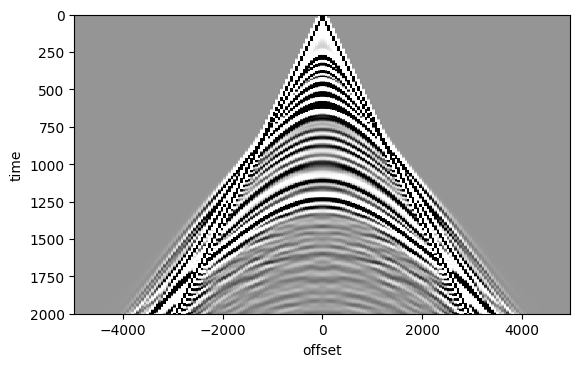

PyObject Text(24,0.5,'time')

In [9]:
figure()
imshow(cmp, vmin=-1, vmax=1, cmap="Greys", aspect=3, extent=[offsets[1], offsets[end], T[end], 0])
xlabel("offset")
ylabel("time")

# Constant velocity NMO correction

In [10]:
nmo_corrected1 = nmo(cmp, 1e-3.*T, offsets, 2000. + 0.*T);

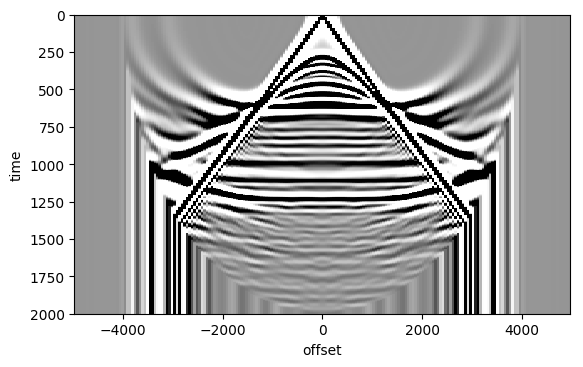

PyObject Text(24,0.5,'time')

In [11]:
figure()
imshow(nmo_corrected1, vmin=-1, vmax=1, cmap="Greys", aspect=3, extent=[offsets[1], offsets[end], T[end], 0])
xlabel("offset")
ylabel("time")

# Windowing
We can see a lot of `artifacts' in the NMO corrected gather above. To avoid some of the artifacts, the midpoint gathers are often windowed to select reflected data only. All events that arrive before the direct wave are removed. A typical window looks like this (Hint: the slope of the triangle is related to the veloctity of the direct wave).


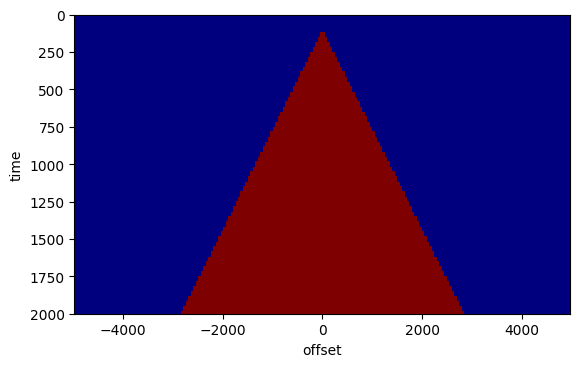

PyObject Text(24,0.5,'time')

In [12]:
# grid
tt = [1e-3*ti for ti in T for h in offsets]
hh = [h for ti in T for h in offsets]

# initialize window to zero and set times later than first arrival to 1.
W=0.*tt;W[tt.>(.1+ abs.(hh)./1500)] = 1
W = reshape(W, size(cmp)[2], size(cmp)[1])
imshow(W', vmin=0, vmax=1, cmap="jet", aspect=3, extent=[offsets[1], offsets[end], T[end], 0])
xlabel("offset")
ylabel("time")


In [13]:
muted = W'.*cmp;

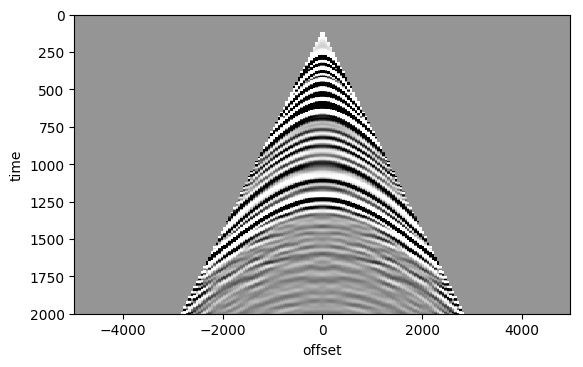

PyObject Text(24,0.5,'time')

In [14]:
figure()
imshow(muted, vmin=-1e0, vmax=1e0, cmap="Greys", aspect=3, extent=[offsets[1], offsets[end], T[end], 0])
xlabel("offset")
ylabel("time")

# Stack power
To figure out which NMO velocity optimally flattens all the events, we can scan through a range of constant NMO velocities and see which events are flattened for which velocity. One way to judge flatness of an event is via the stackpower. The stackpower is just a sum along the offset direction of the values-squared of the NMO-corrected gather:

$ S(t_0,v) = \int\!\!\mathrm{d}h\, d(\tau(t_0,h,v),h)^2 $

The function $ S(t_0,v) $ is called a semblance panel.

The desired NMO velocity can be found by picking the maximum as a function of $t_0$ and $v$ from the semblance panel.

An example of a semblance panel and the resulting NMO velocity is shown below.

In [15]:
v = linspace(1000, 3000, 500)
# scan over velocities
S = zeros(length(T),length(v));
for k = 1:length(v)
    cmp_nmo = nmo(muted, 1e-3.*T, offsets, v[k] .+ 0.*T);
    S[:,k]  = sum(cmp_nmo.^2,2);
end

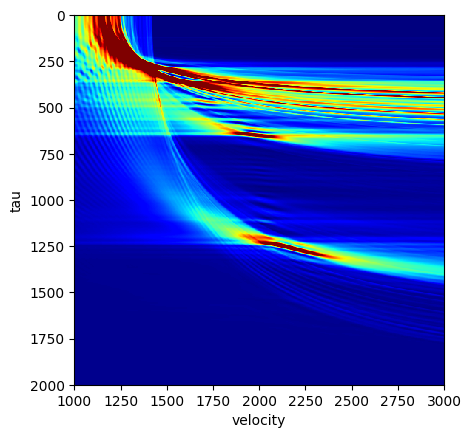

PyObject Text(24,0.5,'tau')

In [16]:
#Plot semblance panel
figure()
imshow(S, vmin=0, vmax=1e3, cmap="jet", aspect=1, extent=[v[1], v[end], T[end], 0])
xlabel("velocity")
ylabel("tau")

In [17]:
#  pick v/tau pairs

In [18]:
tv   = 1e3*[0,    0.30, 0.35, 0.46, 0.65, 1.27, 2.00];
vnmo =     [1500, 1500, 1600, 1700, 2000, 2179, 3000];
spl = Spline1D(tv, vnmo; k=1)
vnmo_all = spl(T);

# Look at the velocity profile with the picked tau/v pairs

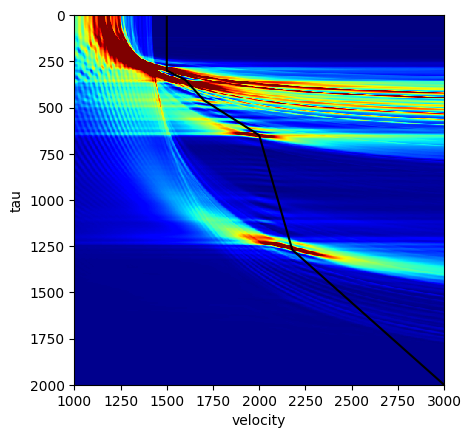

PyObject Text(24,0.5,'tau')

In [19]:
# Enable gui to have the cursor and pick v/tau pairs
figure()
imshow(S, vmin=0, vmax=1e3, cmap="jet", aspect=1, extent=[v[1], v[end], T[end], 0])
plot(vnmo_all, T, "-k")
xlabel("velocity")
ylabel("tau")

In [20]:
nmo_corrected = nmo(muted, 1e-3.*T, offsets, vnmo_all) ;

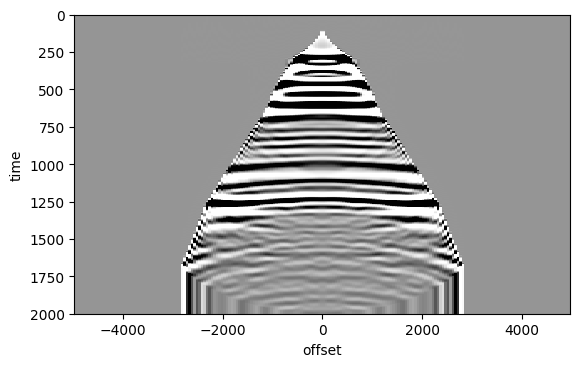

PyObject Text(24,0.5,'time')

In [21]:
figure()
imshow(nmo_corrected, vmin=-1e0, vmax=1e0, cmap="Greys", aspect=3, extent=[offsets[1], offsets[end], T[end], 0])
xlabel("offset")
ylabel("time")

# Velocity analysis

Repeat the above outline procedure for a couple of mipdoint positions xm (e.g., `xm = [500 1000 2000]`). Organize the resulting NMO velocities in a matrix `Vm` (where column i is the NMO velocity for midpoint `xm[i]`) interpolate the results to obtain a velocity for all the midpoints using `Spline1D(xm, VM); spl(all_m)`. Plot the velocity and discuss.

Using this NMO velocity, we can produce an NMO stack. Perform an NMO correction of all the midpoint gathers using the corresponding NMO velocity derived above and sum each along the offset direction. Organize all the stacks in a matrix and plot the result. Also make a stack using a constant NMO velocity. Discuss the results.



In [46]:

function coarse_to_fine(VM, t, xm, all_m)
    spl = Spline2D(t, xm, VM)
    v_full = evalgrid(spl, Float64.(t), all_m)
    return v_full
end

coarse_to_fine (generic function with 1 method)

# Simple example

In this case, I will use the same velocity for the chosen midpoints. In your case you would redo the step above for each chosen midpoint to obtain each column of the matrix

In [93]:
# All midpoints

midpoints = unique(all_m)

# Choose a few midpoints
xm = midpoints[1:40:end]

# Initialize VM

VM = zeros(length(T), length(xm))



# For each in xm pick velocity as above
# for midpoint i pick vnmo_i and set VM[:, i]= vnmo_i

# Fake one for next step, you need to replace it with the picked velocities
VM = linspace(1500, 4500, length(T)) * ones(1, length(xm))


# Interpolate coarse velocity to all midpoints (picking velocity for 401 midpoints is too tidious)
v_full = coarse_to_fine(VM, T, xm, vec(unique(all_m)))

501×401 Array{Float64,2}:
 1500.0  1500.0  1500.0  1500.0  1500.0  …  1500.0  1500.0  1500.0  1500.0
 1506.0  1506.0  1506.0  1506.0  1506.0     1506.0  1506.0  1506.0  1506.0
 1512.0  1512.0  1512.0  1512.0  1512.0     1512.0  1512.0  1512.0  1512.0
 1518.0  1518.0  1518.0  1518.0  1518.0     1518.0  1518.0  1518.0  1518.0
 1524.0  1524.0  1524.0  1524.0  1524.0     1524.0  1524.0  1524.0  1524.0
 1530.0  1530.0  1530.0  1530.0  1530.0  …  1530.0  1530.0  1530.0  1530.0
 1536.0  1536.0  1536.0  1536.0  1536.0     1536.0  1536.0  1536.0  1536.0
 1542.0  1542.0  1542.0  1542.0  1542.0     1542.0  1542.0  1542.0  1542.0
 1548.0  1548.0  1548.0  1548.0  1548.0     1548.0  1548.0  1548.0  1548.0
 1554.0  1554.0  1554.0  1554.0  1554.0     1554.0  1554.0  1554.0  1554.0
 1560.0  1560.0  1560.0  1560.0  1560.0  …  1560.0  1560.0  1560.0  1560.0
 1566.0  1566.0  1566.0  1566.0  1566.0     1566.0  1566.0  1566.0  1566.0
 1572.0  1572.0  1572.0  1572.0  1572.0     1572.0  1572.0  1572.0  1572.0

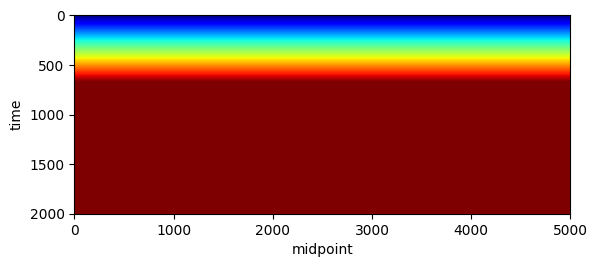

PyObject Text(24,0.5,'time')

In [94]:
imshow(v_full, vmin=1500, vmax=2500, cmap="jet", extent=[midpoints[1], midpoints[end], T[end], T[1]])
xlabel("midpoint")
ylabel("time")

# Final result

You know have the nmo velocity for all midpoint. You can apply NMO correction to each midpoint and stack it to obtain the stacked image of the subsurface. For the above fake velocity model the result would look like that

In [95]:
image = zeros(size(v_full))

for i=1:length(midpoints)
    # Get cmp gather
    Im = find(all_m .== midpoints[i])
    offsets = sort((all_h[Im]))
    inds = sortperm(all_h[Im])
    cmp = Float32.(blocks.data[:, Im[inds]])
    # Correction only needed if multiple trace as a single trace cmp is the zero offset trace that is not modified by nmo correction
    if size(cmp, 2)>1
        # mute it
        # grid
        tt = [1e-3*ti for ti in T for h in offsets]
        hh = [h for ti in T for h in offsets]

        # initialize window to zero and set times later than first arrival to 1.
        W=0.*tt;W[tt.>(.1+ abs.(hh)./1500)] = 1
        W = reshape(W, size(cmp)[2], size(cmp)[1])
        muted = W'.* cmp
        # Correct
        nmo_corrected = nmo(muted, 1e-3.*T, offsets, v_full[:, i])
        # Stack
        image[:, i] = sum(nmo_corrected, 2)
    end
end

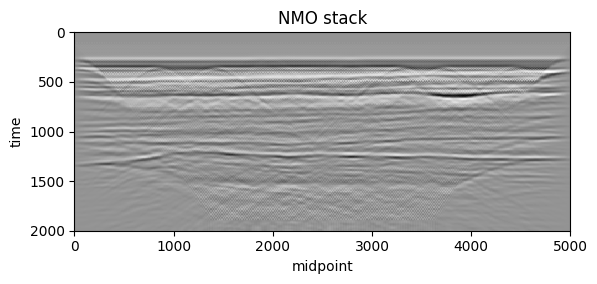

PyObject Text(0.5,1,'NMO stack')

In [96]:
imshow(image, cmap="Greys", extent=[midpoints[1], midpoints[end], T[end], T[1]])
xlabel("midpoint")
ylabel("time")
title("NMO stack")

# Comment

As you can see the image above has a lot of artifacts and noise due to the wrong velocity, you should be able to obtain a clean image with good picked velocities